In [9]:
%matplotlib inline
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import chainer

In [10]:
trainLen = 2000
testLen = 2000
initLen = 100

inSize = outSize = 1
resSize = 1000
a = 0.3 # leaking rate

In [11]:
# load the data
dataset = cp.array(np.loadtxt('MackeyGlass_t17.txt'), dtype=cp.float32)
dataset.shape

(10000,)

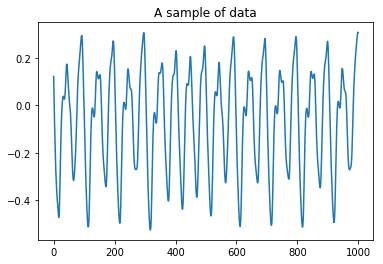

In [12]:
plt.figure(10).clear()
plt.plot(chainer.cuda.to_cpu(dataset[0:1000]))
plt.title('A sample of data')

In [13]:
cp.random.seed(42)
Win = (cp.random.rand(resSize, 1+inSize) - 0.5) * 1

In [14]:
W = cp.array(cp.random.rand(resSize,resSize)-0.5, dtype=cp.float32)

In [15]:
print ('Computing spectral radius...')
eigen = scipy.linalg.eig(chainer.cuda.to_cpu(W))[0]
rhoW = np.max(np.abs(eigen))
print(1.25/rhoW)
W *= 1.25 / rhoW
#W *= 0.135 

Computing spectral radius...
0.13347420195


In [16]:
X = cp.zeros((1+inSize+resSize,trainLen-initLen), dtype=cp.float32)

In [17]:
Yt = dataset[None,initLen+1:trainLen+1]

In [18]:
x = cp.zeros((resSize, 1), dtype=cp.float32)

In [19]:
for t in range(trainLen):
    u = dataset[t]
    x = (1 - a) * x + a * cp.tanh(cp.dot(Win, cp.vstack((cp.array(1), u))) + cp.dot(W, x))
    if t >= initLen:
        X[:, t - initLen] = cp.vstack((cp.array(1), u, x))[:, 0]

In [20]:
# train
reg = 1e-8  # regularization coefficient
X_T = X.T
inside_inv = cp.dot(X,X_T) + reg*cp.eye(1+inSize+resSize, dtype=cp.float32)
Wout = cp.dot(cp.dot(Yt, X_T), 
              chainer.cuda.to_gpu(scipy.linalg.inv(chainer.cuda.to_cpu(inside_inv))))
#Wout = dot( Yt, linalg.pinv(X) )

In [21]:
print(Wout)

[[-18.78125 -24.53125  16.65625 ..., -13.25      8.4375   -9.5    ]]


In [22]:
# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
Y = cp.zeros((outSize, testLen), dtype=cp.float32)
u = cp.array(dataset[trainLen])
for t in range(testLen):
    x = (1-a)*x + a*cp.tanh(cp.dot(Win, cp.vstack((cp.array(1), u))) + cp.dot(W, x))
    y = cp.dot(Wout, cp.vstack((cp.array(1), u, x)))
    Y[:,t] = y
    # generative mode:
    u = y
    ## this would be a predictive mode:
    #u = data[trainLen+t+1] 

In [23]:
# compute MSE for the first errorLen time steps
errorLen = 500
mse = cp.sum(cp.square(dataset[trainLen+1:trainLen+errorLen+1] - Y[0,0:errorLen] ) ) / errorLen
print ('MSE = ' + str( mse ))

MSE = inf


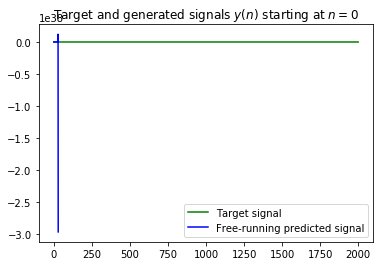

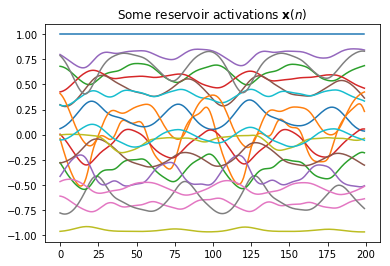

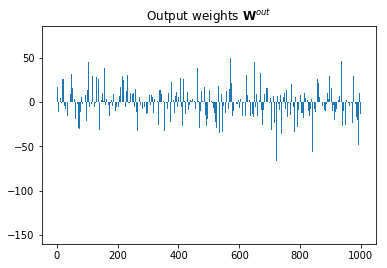

In [24]:
# plot
plt.figure(1).clear()
plt.plot(chainer.cuda.to_cpu(dataset[trainLen+1:trainLen+testLen+1]), 'g' )
plt.plot(chainer.cuda.to_cpu(Y.T), 'b')
plt.title('Target and generated signals $y(n)$ starting at $n=0$')
plt.legend(['Target signal', 'Free-running predicted signal'])

plt.figure(2).clear()
plt.plot(chainer.cuda.to_cpu(X[0:20,0:200].T))
plt.title('Some reservoir activations $\mathbf{x}(n)$')

plt.figure(3).clear()
plt.bar( range(1+inSize+resSize), chainer.cuda.to_cpu(Wout.T))
plt.title('Output weights $\mathbf{W}^{out}$')

plt.show()